# Posologie

Un français adulte sur 4, soit 16 millions de personnes, souffre d'acouphènes (source : *le Monde*). Pourtant, il n'existe pas encore de réel traitement. Les personnes diagnostiquées peuvent porter un appareil auditif, qui permet d'en diminuer l'intensité, mais pas de guérir l'acouphène. Diapason offre cette possibilité aux utilisateurs, à partir de différents types de thérapies, et de programmes personnalisés en fonction du 'diagnostic', lui même réalisé par l'application. Mais est-ce efficace ? Les 'patients' sont-ils rigoureux et réussissent-ils à suivre leur prescription ? Un traitement non suivi ne peut aboutir à des résultats, il est donc important de savoir si les programmes ne sont pas trop durs à suivre pour pouvoir les modifier en conséquence. Pour cela, nous allons avoir besoin d'étudier l'évolution de l'assiduité des utilisateurs en fonction du temps, mais aussi de repérer les thérapies les plus appréciées et celles plus difficiles à suivre. De plus, il sera intéressant de voir si l'âge et l'intensité de la nuisance ont un impact sur l'assiduité de l'utilisateur. Si oui, il faudrait alors peut-être adapter le programme à ces paramètres.

## Existe-il des types de thérapies plus simples à suivre que les autres (en % par rapport à l’objectif) ?

Cette application est basée sur le principe d'auto-médication. Ainsi, bien que des objectifs soient définis par l'application, l'utilisateur est libre de les atteindre ou non, en fonction de son temps, son engagement, mais aussi de la difficulté du programme et des résultats constatés. Une thérapie non suivie ne pouvant porter ses fruits, il est essentiel d'identifier les thérapies qui seraient trop difficiles ou moins attractives afin de pouvoir les améliorer.

<div class="alert alert-info"><h4>Note</h4><p>Cette application propose quatre types de thérapies différentes : cognitive et comportementale (abréviée ci-après par cbt), sonore (abréviée ci-après par trt), relaxation et inhibition résiduelle. En fonction du diagnostic de l'utilisateur, l'application lui propose un programme, c'est à dire une liste de quatre objectifs correspondant aux durées à passer chaque semaine sur chacune des thérapies. Ce programme est donc personnalisé et a vocation à s'adapter à l'acouphène de l'utilisateur. Nous considérons qu'une thérapie est "simple" lorsque le temps effectivement passé par l'utilisateur sur l'exercice est important relativement à l'objectif fixé.</p></div>

### Les données nécessaires à l'analyse

Pour approcher cette question, nous utilisons dans un premier temps la collection States.
Les données qui nous intéressent sont celles de "progression"-> "program"-> "weeklyDuration" où nous sélectionnons en fonction de la valeur "trt", "cbt", "relaxation" ou "residualInhibition", la valeur de "objective"/"progression". Nous travaillons uniquement sur les utilisateurs ayant une licence puisque ce sont les seuls à pouvoir suivre les différentes thérapies et regardons les données relatives à la dernière semaine d'activité de chaque utilisateur.


In [1]:
import pymongo # conda install pymongo
import pandas as pd
from datetime import datetime
from pprint import pprint as prettyprint


In [2]:
client = pymongo.MongoClient() 

csdiapason_db = client['csdiapason']

events_collection = csdiapason_db['events']
licenses_collection = csdiapason_db['licenses']
states_collection = csdiapason_db['states']
users_collection = csdiapason_db['users']

### Visualisation des données

Avant d'effectuer une analyse statistique des données, il est intéressant de visualiser quelques exemples et de connaître certaines informations générales comme la moyenne ou l'écrat type.

Ici, vous avez donc le code permettant d'afficher ces données (graphiques, résultats statitiques)

In [3]:
dict_2=licenses_collection.aggregate(pipeline=
    [
        {
            '$lookup': {
                'from': 'states',
                'localField': 'user',
                'foreignField': 'user',
                'as': 'states'
            }
        },
        {
            '$unwind' : '$states'
        }])
print('---structure des champs qui nous intéressent---')
dict_2.next()
dict_2.next()
dict_2.next()
prettyprint(dict_2.next()["states"]["progression"]["program"]["weeklyDuration"])

---structure des champs qui nous intéressent---
{'cbt': {'objective': 1560, 'progression': 0},
 'relaxation': {'objective': 1740, 'progression': 0},
 'residualInhibition': {'objective': 1560, 'progression': 0},
 'trt': {'objective': 1440, 'progression': 0}}


In [4]:
nb=licenses_collection.count_documents({})

print('La base de connées comprend '+str(nb)+' utilisateurs avec une licence.')

La base de connées comprend 755 utilisateurs avec une licence.


In [5]:
dict2=licenses_collection.aggregate(pipeline=
    [
        {
            '$lookup': {
                'from': 'states',
                'localField': 'user',
                'foreignField': 'user',
                'as': 'states'
            }
        },
        {
            '$unwind' : '$states'
        }])
val_cbt_obj=[]
val_relax_obj=[]
val_residual_obj=[]
val_trt_obj=[]
for user in dict2:
    try:
        b=user["states"]["progression"]["program"]["weeklyDuration"]["cbt"]["objective"]
    except KeyError:
        b=0
    try:
        d=user["states"]["progression"]["program"]["weeklyDuration"]["relaxation"]["objective"]
    except KeyError:
        d=0    
    try:
        f=user["states"]["progression"]["program"]["weeklyDuration"]["residualInhibition"]["objective"]
    except KeyError:
        f=0
    try:
        h=user["states"]["progression"]["program"]["weeklyDuration"]["trt"]["objective"]
    except KeyError:
        h=0
    val_cbt_obj.append(b)
    if d!= None :
        val_relax_obj.append(d)
    val_residual_obj.append(f)
    val_trt_obj.append(h)
    
val_cbt_obj=[i/60 for i in val_cbt_obj]
val_relax_obj=[i/60 for i in val_relax_obj]
val_residual_obj=[i/60 for i in val_residual_obj]
val_trt_obj=[i/60 for i in val_trt_obj]
    

In [6]:
import matplotlib.pyplot as plt
import pylab

Text(0.5, 1.0, "objectifs fixés par l'application en fonction de la thérapie en minutes")

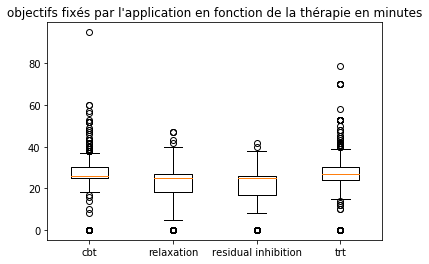

In [7]:
plt.boxplot([val_cbt_obj, val_relax_obj, val_residual_obj,val_trt_obj])
BoxName = ['cbt','relaxation','residual inhibition', 'trt']
pylab.xticks([1,2,3,4], BoxName)
plt.title("objectifs fixés par l'application en fonction de la thérapie en minutes")

L'application donne 15 minutes d'exercices par jour, soit 105 minutes par semaine. Ces 105 minutes sont reparties différemment en fonction du besoin des utilisateurs, c'est pourquoi on peut voir des outliers avec quasiment 100 minutes d'exercices en cbt et 0 en trt.

On constate donc qu'en moyenne les objectifs fixés par l'application pour chaque thérapie sont comparables en temps, il n'y a donc a priori pas de raison qu'il soit plus difficile de compléter l'objectif fixé pour cbt que pour trt par exemple. Dans la suite, nous pourrons donc comparer les taux de complétion des objectifs (c'est à dire le rapport temps effectué/objectif).

### Les algorithmes et métriques utilisés

Nous souhaitons savoir, pour chacune des thérapies, si les utilisateurs complètent ou non leurs objectifs, nous allons donc, pour chaque thérapie, regarder la moyenne est les quartiles du pourcentage de complétion des données. Ainsi nous pourrons voir si certaines thérapies sont plus souvent suivies dans leur intégralité que d'autres.

### Résultats

In [8]:
#Vous avez ici le code et les graphiques de résultats associés, ainsi que les tableaux de résultats.
dict2= licenses_collection.aggregate(pipeline=
    [
        {
            '$lookup': {
                'from': 'states',
                'localField': 'user',
                'foreignField': 'user',
                'as': 'states'
            }
        },
        {
            '$unwind' : '$states'
        }

 

    ])
val_cbt=[]
val_relax=[]
val_residual=[]
val_trt=[]
for user in dict2:
    try:
        a=user["states"]["progression"]["program"]["weeklyDuration"]["cbt"]["progression"]
        b=user["states"]["progression"]["program"]["weeklyDuration"]["cbt"]["objective"]
    except KeyError:
        a=0
        b=1
    try:
        c=user["states"]["progression"]["program"]["weeklyDuration"]["relaxation"]["progression"]
        d=user["states"]["progression"]["program"]["weeklyDuration"]["relaxation"]["objective"]
    except KeyError:
        c=0
        d=1
    if d==None:
        d=1
    try:
        e=user["states"]["progression"]["program"]["weeklyDuration"]["residualInhibition"]["progression"]
        f=user["states"]["progression"]["program"]["weeklyDuration"]["residualInhibition"]["objective"]
    except KeyError:
        e=0
        f=1
    try:
        g=user["states"]["progression"]["program"]["weeklyDuration"]["trt"]["progression"]
        h=user["states"]["progression"]["program"]["weeklyDuration"]["trt"]["objective"]
    except KeyError:
        g=0
        h=1
    val_cbt.append(a/b*100)
    val_relax.append(c/d*100)
    val_residual.append(e/f*100)
    val_trt.append(g/h*100)




In [9]:
import matplotlib.pyplot as plt
import pylab

Text(0.5, 1.0, 'complétion des objectifs en fonction de la thérapie (en %)')

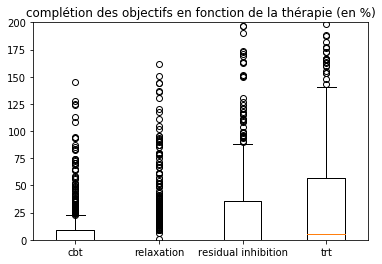

In [10]:
plt.boxplot([val_cbt, val_relax, val_residual,val_trt])
plt.ylim(0,200)
BoxName = ['cbt','relaxation','residual inhibition', 'trt']
pylab.xticks([1,2,3,4], BoxName)
plt.title('complétion des objectifs en fonction de la thérapie (en %)')

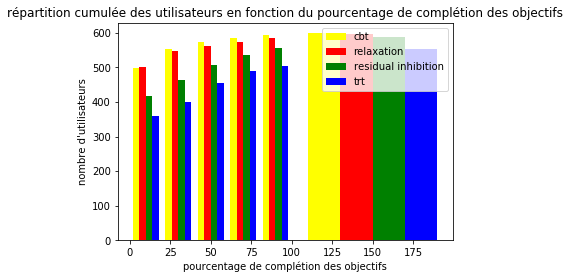

In [11]:
hist=plt.hist([val_cbt,val_relax, val_residual, val_trt],bins=[0,20,40,60,80,100,200], cumulative=True, color=['yellow','red','green','blue'], label=['cbt','relaxation','residual inhibition','trt'])
plt.ylabel("nombre d'utilisateurs")
plt.xlabel('pourcentage de complétion des objectifs')
plt.title("répartition cumulée des utilisateurs en fonction du pourcentage de complétion des objectifs")
plt.legend()

Notons qu'il est normal de trouver des valeurs faibles puisque nous regardons les valeurs de la dernière semaine, qui peut donc correspondre au milieu d'une semaine d'un utilisateur.

Aussi, certains utilisateurs complètent leurs objectifs à 8000%, c'est pourquoi les 4 barres ne sont pas exactement à la même hauteur pour complétion < 200%

### Conclusion

Finalement, en ne considérant que la dernière semaine d'activité de chaque individu, on constate que la thérapie la plus suivie est trt, puis residual inhibition, puis cbt et finalement relaxation. Cependant, il serait intéressant de voir si cette répartition est constatée dès les premières semaines ou si au contraire elle évolue au fil des semaines d'utilisation. Certains utilisateurs se décourageant petit à petit, peut-être que les utilisateurs les plus assidus ont des préférences différentes. Cela nous amène donc à notre deuxième question qui est d'étudier l'évolution au cours du temps de certains paramètres d'utilisation de l'application.

## Comment l’assiduité des utilisateurs évolue-t-elle au cours du temps ?

### Introduction

#### Portée de l'étude

Intéressons-nous à présent à l'évolution du comportement des utilisateurs au cours du temps. Nous nous pencherons tout particulièrement sur leur assiduité et ce pour plusieurs raisons. Tout d'abord d'un point de vue médical, il est intéressant d'étudier l'influence de l'assiduité des utlisateurs sur la nuisance de leur acouphène afin de cibler les thérapies qui nécessitent une fréquence de suivi importante pour être efficace ou au contraire cibler celles qui peuvent apporter des résultats bénéfiques avec une utilisation simple ponctuelle. Par ailleurs, d'un point de vue industriel, identifier si les types de thérapies les plus plébiscitées par les utilisateurs varient avec l'assiduité peut se révéler utile afin de modifier l'application pour qu'elle propose les meilleurs exercices au meilleur moment de sorte à ne pas décourager les utilisateurs et ainsi les fidéliser. Finalement d'un point de vue commercial, mettre en évidence les moments où une large partie des utilisateurs décroche puis abandonne constitue une précieuse information afin de par exemple de relancer les utilisateurs à l'aide de notifications aux moments idoines.

#### Définition des termes

Cette étude faisant intervenir la variable temps, il est nécessaire de préciser la manière dont nous allons procéder. Remarquons tout d'abord que moyenner les variables de chaque individu au cours du temps physique ne serait pas pertinent. En effet, tous les utilisateurs n'ont pas souscrit à Diapason en même temps. Ainsi, la semaine du 16 mars 2020 peut correspondre à la huitième semaine d'utilisation d'une personne mais à la deuxième semaine d'utilisation d'une autre. Certains utilisateurs n'avaient même pas acheté de licence à cette date. Nous voyons donc qu'il est nécessaire de définir une nouvelle notion de temps.

<div class="alert alert-info"><h4>Semaines d'utilisation</h4><p> Dans la suite de cette étude, le temps sera décompté en semaines à partir du jour d'achat de la licence. Par exemple, pour un utilisateur ayant acheté sa licence le 1er janvier 2020, sa première semaine d'utilisation s'étale du 1 au 7 janvier, sa deuxième semaine d'utilisation du 7 au 13 janvier, etc... Les expressions "au cours du temps" ou "au fil des semaines" ont donc ici des significations légèrement différentes puisqu'elles font référence à l'écoulement du temps à partir d'un point de référence fixe : la date d'achat de la licence. </p></div>

#### Traitement des données

Afin de respecter cette définition de semaines d'utilisation, il nous faut faire coïncider les timelines de chaque personne de sorte à pouvoir comparer les comportements des utilisateurs au fil des semaines. Cela nécessite un traitement des données particulier réalisé par les fonctions ci-dessous (l'exécution peut prendre quelques secondes).

In [12]:
def recap_activites(user,timeinf,timesup):

    l=[]

    many_events_cursor=events_collection.find({
            "$or":[{"$and":[{"type":"PROGRAM_START"},{"data.objectives":{"$exists":True}}]},{"type":"ACTIVITY_COMPLETE"}],
            "$and":[{"date":{"$gte":timeinf}},{"date":{"$lte":timesup}}], #renseigner la plage temporelle à analyser
            'user': user #renseigner l'utilisateur
        },
        {
            "_id":0,"date":1,"type":1,"data.objectives":1,"data.activity":1,"data.duration":1
        })
    
    for event in many_events_cursor:
        l.append(event)
        #prettyprint(event)
    

    n=len(l)
    i=0
    recap={'date':[],'objectifs':[],'resultats':[]}
    while i<n:
        if l[i]["type"]=="PROGRAM_START":
            obj={}
            dat=l[i]['date']
            obj=l[i]['data']['objectives']
            for therapy in obj.keys():
                if obj[therapy]==None:
                    obj[therapy]=0
            for therapy in ['trt','cbt','residualInhibition','relaxation']:
                if therapy not in obj.keys():
                    obj[therapy]=0
            res={'trt':0,'cbt':0,'relaxation':0,'residualInhibition':0}
            i+=1
            while i<n and l[i]["type"]=="ACTIVITY_COMPLETE":
                if l[i]['data']['activity'] in ['lostRecipe','toyFactory','associationSort']:
                    res['cbt']+=l[i]['data']['duration']
                if l[i]['data']['activity'] in ['coherentBreathing','abdominalBreathing','squareBreathing']:
                    res['relaxation']+=l[i]['data']['duration']
                if l[i]['data']['activity'] in ['whiteNoise','keepTheShape','smoothieBar','tempo','catchThem','CatchThem']:
                    res['residualInhibition']+=l[i]['data']['duration']
                if l[i]['data']['activity'] in ['constellations','lullaby','plinko','theIsland','simons',]:
                    res['trt']+=l[i]['data']['duration']
                i+=1
            recap['date'].append(dat)
            recap['objectifs'].append(obj)
            recap['resultats'].append(res)
            i-=1
        i+=1

    return(recap)

def progression_par_semaine(user,time_start):
    progression=[]
    timeinf=time_start
    while timeinf<1591696983:
        recap=recap_activites(user,timeinf,timeinf+604800)
        if recap['date']==[]:
            progression.append({})
        else:
            obj_cumul={'trt': 0, 'cbt': 0, 'relaxation': 0, 'residualInhibition': 0}
            res_cumul={'trt': 0, 'cbt': 0, 'relaxation': 0, 'residualInhibition': 0}
            info={'trt': [], 'cbt': [], 'relaxation': [], 'residualInhibition': []}
            for i in range(0,len(recap['date'])):
                for therapy in ['trt','cbt','residualInhibition','relaxation']:
                    obj_cumul[therapy]+=recap['objectifs'][i][therapy]
                    res_cumul[therapy]+=recap['resultats'][i][therapy]
            for therapy in ['trt','cbt','residualInhibition','relaxation']:
                info[therapy].append(obj_cumul[therapy])
                info[therapy].append(res_cumul[therapy])
                #info[therapy].append(res_cumul[therapy]/obj_cumul[therapy])
            progression.append(info)
        timeinf+=604800
    return(progression)

def allweeklyprogressions():
    
    licenses=[]
    many_licenses_cursor=licenses_collection.find({},{"_id":0,"user":1,"activationDate":1})
    for event in many_licenses_cursor:
        licenses.append(event)

    weeklyprogressions=[]
    
    for i in range(0,len(licenses)):
        user=licenses[i]['user']
        activationdate=licenses[i]['activationDate']
        
        weeklyprogressions.append(progression_par_semaine(user,activationdate))
    
    return(weeklyprogressions)

"""

Explication rapide de ces fonctions :

La fonction allweeklyprogression() renvoie une liste dont chaque élément est relatif
à un utilisateur possédant une licence. Ces éléments sont eux-mêmes des listes contenant
les uns après les autres des dictionnaires comportants des données sur les activités
semaine par semaine de l'utilisateur en question. Pour résumer, chacun de ces dictionnaires
fait référence aux activités d'une personne sur une période de une semaine (les dictionnaires
sont créés à partir de la date de création de la licence et s'arrêtent à la semaine présente).
Dans chaque dictionnaire sont répertiorés pour les quatre types de thérapies les temps en
secondes des objectifs et des résultats (temps effectivement passé par l'utilisateur sur des
activités relatives à cette thérapies).

Le code ci-dessous permet de nettoyer les données obtenues. Ainsi, les utilisateurs n'ayant
jamais ouvert l'application (donc repérés par une suite de dictionnaires vides) seront
supprimés. De même, les utilisateurs s'étant vus proposer des objectifs mais n'ayant que des
résultats nuls (aucune activité suivie) seront considérés comme "absents" au même titre que
les utilisateurs n'ayant pas du tout ouvert l'application.

"""

awp=allweeklyprogressions()

print(" ")
print("Quelques chiffres à titre informatif :")
print(" ")
print("La base de données comprend "+ str(len(awp))+ " utilisateurs ayant acheté une licence...")

l=[]
awp12=awp
for i in range(0,len(awp)):
    l=awp12[i]
    for j in range(0,len(l)):
        if l[j]!={}:
            if l[j]['trt'][1]==0 and l[j]['cbt'][1]==0 and l[j]['residualInhibition'][1]==0 and l[j]['relaxation'][1]==0:
                awp12[i][j]={}
l=[]
awp2=[]
for i in range(0,len(awp12)):
    l=awp12[i]
    if l!=[] and l[0]=={}:
        l.pop(0)
    if l!=[] and l[-1]=={}:
        l.pop()
    if l!=[]:
        awp2.append(l)


print("...parmi lesquels "+ str(len(awp2))+ " ont utilisé au moins une fois Diapason.")


"""

Explication rapide de cette dernière partie :

Nous construisons une liste semaines qui comprend 29 éléments chacun relatif à une semaine
d'utilisation (aucun utilisateur n'a utilisé Diapason plus de 29 semaines). Chaque élement
est lui-même une liste dont le premier élément est le nombre d'utilisateurs ayant été actifs
cette semaine-là suivi d'un dictionnaire répertoriant pour chacune des 4 thérapies les objectifs
cumulés de tous les utilisateurs, les résultats cumulés des personnes qui n'avaient pas
d'objectif sur cette thérapie, les résultats cumulés des personnes qui avaient un objectif sur
cette thérapie, les résultats cumulés de toutes les personnes et enfin le taux de complétion
pour les personnes ayant un objectif (d'où l'utilité séparer les personnes avec et sans objectifs
sinon on divise par zéro...). 

"""
completion={i:{'trt': [], 'cbt': [], 'relaxation': [], 'residualInhibition': []} for i in range(0,29)}
semaines=[]
for i in range (0,29):
    count=0
    objectif={'trt': 0, 'cbt': 0, 'relaxation': 0, 'residualInhibition': 0}
    resultat_avecobj={'trt': 0, 'cbt': 0, 'relaxation': 0, 'residualInhibition': 0}
    resultat_sansobj={'trt': 0, 'cbt': 0, 'relaxation': 0, 'residualInhibition': 0}
    for j in range (0,len(awp2)):
        if len(awp2[j])>=(i+1):
            dic=awp2[j][i]
            if dic!={}:
                count+=1
                for therapy in ['trt','cbt','residualInhibition','relaxation']:
                    objectif[therapy]+=dic[therapy][0]
                    if dic[therapy][0]!=0:
                        resultat_avecobj[therapy]+=dic[therapy][1]
                        completion[i][therapy].append(dic[therapy][1]/dic[therapy][0])
                    else:
                        resultat_sansobj[therapy]+=dic[therapy][1]
    semaines.append([count,{'trt': [objectif['trt'],
                                    resultat_sansobj['trt'],
                                    resultat_avecobj['trt'],
                                    resultat_sansobj['trt']+resultat_avecobj['trt'],
                                    resultat_avecobj['trt']/objectif['trt']],
                            'cbt': [objectif['cbt'],
                                    resultat_sansobj['cbt'],
                                    resultat_avecobj['cbt'],
                                    resultat_sansobj['cbt']+resultat_avecobj['cbt'],
                                    resultat_avecobj['cbt']/objectif['cbt']],
                     'relaxation': [objectif['relaxation'],
                                    resultat_sansobj['relaxation'],
                                    resultat_avecobj['relaxation'],
                                    resultat_sansobj['relaxation']+resultat_avecobj['relaxation'],
                                    resultat_avecobj['relaxation']/objectif['relaxation']],
             'residualInhibition': [objectif['residualInhibition'],
                                    resultat_sansobj['residualInhibition'],
                                    resultat_avecobj['residualInhibition'],
                                    resultat_sansobj['residualInhibition']+resultat_avecobj['residualInhibition'],
                                    resultat_avecobj['residualInhibition']/objectif['residualInhibition']]}])

print("On compte "+str(semaines[2][0])+" utilisateurs actifs lors de leur 3ème semaine d'utilisation et seulement "+str(semaines[9][0])+" pour leur 10ème semaine d'utilisation.")

 
Quelques chiffres à titre informatif :
 
La base de données comprend 755 utilisateurs ayant acheté une licence...
...parmi lesquels 750 ont utilisé au moins une fois Diapason.
On compte 180 utilisateurs actifs lors de leur 3ème semaine d'utilisation et seulement 53 pour leur 10ème semaine d'utilisation.


### Exploitation des données

Selon la définition que l'on donne au terme "assiduité", les métriques utilisées pour la quantifier seront diverses et variées. Dans cette partie, nous proposons d'étudier l'assiduité sous deux angles différents : l'activité des utilisateurs et la complétion des objectifs.

#### 1- Activité des utilisateurs au cours du temps

Une première manière de mesurer l'assiduité d'un utilisateur consiste à regarder si ce dernier se rend régulièrement sur l'application et y est actif.

<div class="alert alert-info"><h4>Utilisateur actif</h4><p> Un utilisateur est considéré comme actif sur Diapason lors de la semaine S lorsqu'il passe du temps (durée non nulle) sur au moins un des exercices de thérapie proposés durant la semaine S. Attention! Un utilisateur actif lors de sa huitième semaine d'utilisation n'a pas forcément été actif de manière continue depuis sa première semaine d'utilisation. Simplement, il a a minima été actif une première fois (marquant la début de sa première semaine d'utilisation) puis une seconde fois huit semaines plus tard.</p></div>

Il n'est néanmoins pas pertinent de représenter l'évolution du nombre d'utilisateurs actifs au cours des semaines. En effet, les utilisateurs n'ayant acheté une licence que récemment viendraient gonfler les chiffres des premières semaines d'utilisation et ne seraient évidemment pas être pris en compte dans les semaines d'après. Il nous faut plutôt nous intéresser à l'évolution du nombre d'utilisateurs actifs par rapport au nombre d'utilisateurs potentiels au fil des semaines.

 <div class="alert alert-info"><h4>Utilisateurs potentiels</h4><p> Nous appelons ici utilisateur potentiel de la Sième semaine d'utilisation toute personne dont la première semaine d'utilisation date d'il y a au moins S semaines. Autrement dit, il s'agit d'une personne utilisant l'application depuis assez longtemps pour en être à sa Pième semaine d'utlisation où P est supérieur ou égal à S.</p></div>

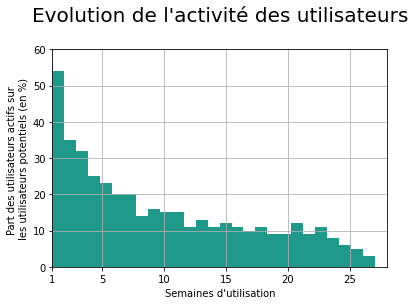

In [13]:
from math import *
import matplotlib.pyplot as plt
import numpy as np

weeklylist=awp2

mois={i:[] for i in range (0,9)}

for e in weeklylist:
    if len(e)<=36:
        mois[(len(e)-1)//4].append(e)

A=np.zeros((7,28))
M=np.zeros((7,28))
count=np.zeros((7,28))
countactifs=np.zeros((28))
for i in range (0,7):
    for j in range(0,28):
        for e in mois[i]:
            if len(e)>j and e[j]!={}:
                A[i][j]+=1
                countactifs[j]+=1
            if len(e)>j:
                count[i][j]+=1

Mat=np.zeros((7,28))
for i in range (0,7):
    for j in range(0,28):
        if count[i][j]!=0:
            Mat[i][j]=100*A[i][j]/count[i][j]
                
for i in range(0,7):
    for j in range(0,28):
        M[i][j]=False
        if j>4*i+3:
            M[i][j]=True
            

weeks={i:[] for i in range (0,28)}

for e in weeklylist:
    if len(e)<=28:
        weeks[(len(e)-1)].append(e)

n=0
for i in range(0,28):
    n+=len(weeks[i])
counttotal=np.zeros((28))
counttotal[0]=n
for i in range(1,28):
    counttotal[i]=counttotal[i-1]-len(weeks[i-1])

l=[]
for i in range(0,len(countactifs)):
    n=int(round(100*countactifs[i]/counttotal[i]))
    for j in range(0,n):
        l.append(i+1)

n, bins, patches = plt.hist(l, 27,facecolor="#1f998a",align='mid')
plt.xlabel("Semaines d'utilisation")
plt.ylabel("Part des utilisateurs actifs sur \nles utilisateurs potentiels (en %)")
plt.title("Evolution de l'activité des utilisateurs\n",fontsize=20)
plt.xlim(1,28)
plt.xticks([1,5,10,15,20,25])
plt.ylim(0, 60)
plt.grid()
plt.show()

Nous pouvons remarquer que la part des utilisateurs actifs sur les utilisateurs potentiels decroît sensiblement entre la première et la deuxième semaine, passant de 54% à 33%. Cette chute est en partie due aux utilisateurs qui ne sont pas satisfaits lors de leur première utilisation de Diapason et qui arrêtent donc de se rendre sur l'application. Le taux décroît ensuite plus progressivement pour se stabiliser à partir de la douzième semaine aux alentours de 10% d'activité. Cette étude nous montre donc que la plupart des utilisateurs n'est pas particulièrement assidue et que seul un noyau dur d'utilisateurs représentant environ 10% des utilisateurs ayant une licence arrive à maintenir un suivi des thérapies relativement constant au cours du temps. Cette valeur de 10% est cependant à prendre avec des pincettes puisque les résultats de cette étude seraient les mêmes si 20% des utilisateurs venaient régulièrement une semaine sur deux.

Nous pouvons également nous demander si cette tendance dépend de la date d'achat de l'application. Pour cela, nous réalisons une étude de cohorte en regroupant les utilisateurs par date d'achat de leur licence. Dans notre cas, nous formons 7 groupes dont les membres correspondent aux utlisateurs ayant acheté leur licence pendant une certaine période (environ 4 semaines). Le graphique suivant nous montre pour chaque groupe, semaine par semaine, le ratio du nombre d'utilisateurs actifs sur le nombre d'utilisateurs potentiels. Il y a donc dans chaque groupe une partie des utilisateurs qui ne sont pas des utilisateurs potentiels des dernières semaines, ils ne rentrent alors pas en compte dans les calculs de la semaine considérée.

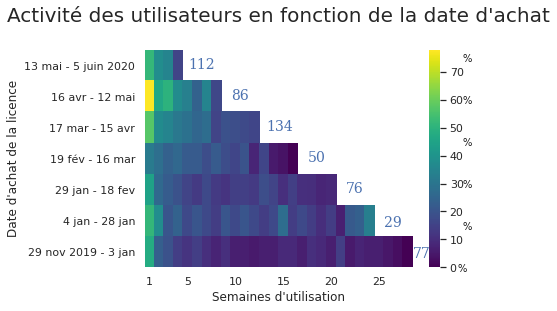

In [14]:
import seaborn as sns
sns.set(style="white")
sns.heatmap(Mat,cmap='viridis',mask=M,
            xticklabels=[1,None,None,None,5,None,None,None,None,10,None,None,None,None,15,None,None,None,None,20,None,None,None,None,25,None,None,None],
            yticklabels=['13 mai - 5 juin 2020','16 avr - 12 mai','17 mar - 15 avr','19 fév - 16 mar','29 jan - 18 fev','4 jan - 28 jan','29 nov 2019 - 3 jan'])
plt.xlabel("Semaines d'utilisation")
plt.ylabel("Date d'achat de la licence")
plt.title("Activité des utilisateurs en fonction de la date d'achat\n",fontsize=20)

font = {'family': 'serif',
        'color':  'b',
        'weight': 'normal',
        'size': 14,
        }

plt.text(4.6, 0.6, "112",fontdict=font)
plt.text(9, 1.6, "86",fontdict=font)
plt.text(12.7, 2.6, "134",fontdict=font)
plt.text(17, 3.6, "50",fontdict=font)
plt.text(21, 4.6, "76",fontdict=font)
plt.text(25, 5.7, "29",fontdict=font)
plt.text(28, 6.7, "77",fontdict=font)

font = {'family': 'DejaVu Sans',
        'color':  'k',
        'weight': 'normal',
        'size': 10,
        }

plt.text(33.2, 0.38, "%",fontdict=font)
plt.text(33.2, 1.72, "%",fontdict=font)
plt.text(33.2, 3.1, "%",fontdict=font)
plt.text(33.2, 4.44, "%",fontdict=font)
plt.text(33.2, 5.8, "%",fontdict=font)
plt.text(32.7, 7.15, "%",fontdict=font)


plt.show()

Nous avons rajouté au bout de chacune des 7 lignes le nombre de membres du groupe correspondant. Ainsi, sur les 86 utilisateurs ayant acheté une licence entre le 16 avril et le 12 mai 2020, 40% d'entre eux ont utilisé l'application 3 semaines après avoir acheté la licence (il s'agit donc ici de la semaine 4).

Au-delà de nous informer quant à l'activité décroissante des utilisateurs au cours du temps, cette étude de cohorte permet de voir les différences d'assiduité entre les différents groupes. On peut ainsi remarquer que l'assiduité des utilisateurs récents semble être légèrement plus élevée que celles des utilisateurs les plus anciens pour une même semaine d'utilisation. On peut supposer que cette observation reflète le fait que les différentes améliorations et autres mises à jour de Diapason semblent rendre l'expérience d'utilisation plus agréable et ainsi fidéliser davantage les utilisateurs.

#### 2- Complétion des objectifs au cours du temps

Maintenant que nous avons étudié l'évolution de l'activité des utilisateurs au cours du temps, nous allons désormais nous intéresser plus en détails à la nature de cette activité. En effet, l'assiduité implique une certaine régularité d'utilisation mais demande aussi d'être consciencieux dans la validation des objectifs. Pour quantifier l'application des utilisateurs, nous prenons comme métrique la complétion des objectifs en fonction des 4 types de thérapie.

<div class="alert alert-info"><h4>Complétion</h4><p> La complétion correspond au rapport entre la durée passée par l'utilisateur sur des exercices relatifs à une thérapie et la durée recommandée par l'application. Diapason propose en effet 4 objectifs personnalisés pour chacune des 4 thérapies.</p></div>

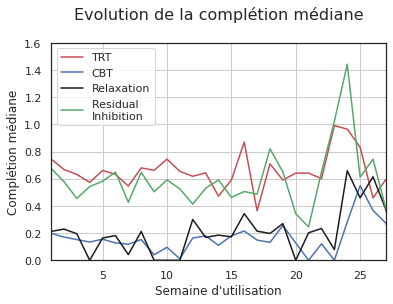

In [15]:
restrt=[]
rescbt=[]
resrel=[]
resinh=[]
for i in range(0,len(semaines)):
    count=semaines[i][0]
    restrt.append(np.median(np.array(completion[i]['trt'])))
    rescbt.append(np.median(np.array(completion[i]['cbt'])))
    resrel.append(np.median(np.array(completion[i]['relaxation'])))
    resinh.append(np.median(np.array(completion[i]['residualInhibition'])))

plt.plot([i for i in range(1,30)],restrt,'r-',label='TRT')
plt.plot([i for i in range(1,30)],rescbt,'b-',label='CBT')
plt.plot([i for i in range(1,30)],resrel,'k-',label='Relaxation')
plt.plot([i for i in range(1,30)],resinh,'g-',label='Residual \nInhibition')
plt.xlabel("Semaine d'utilisation")
plt.ylabel("Complétion médiane")
plt.title("Evolution de la complétion médiane\n", fontsize=16)
plt.grid()
plt.legend(loc=2)
plt.axis([1, 27, 0, 1.6])
plt.show()

Ce graphique nous montre pour chaque semaine d'utilisation la complétion médiane des utilisateurs actifs lors de cette semaine. Nous pouvons remarquer plusieurs choses sur ce graphique. Tout d'abord, comme nous l'avons vu précédemment, les thérapies les plus suivies sont les thérapies sonore et d'inhibition résiduelle, et ce, quelle que soit la semaine d'utilisation. Malgré tout, même pour ces thérapies plébiscitées, 50% des utilisateurs remplissent moins de 70% de leurs objectifs. Les thérapies cognitive et comportementale et la relaxation ne sont pas autant appréciées et ne motivent pas plus d'un utilisateur sur deux à remplir ne serait-ce que 20% des objectifs. A remarquer néanmoins une hausse de ces taux à partir de la 23ème semaine d'utilisation. Nous pouvons ainsi imaginer que ces thérapies commencent à apporter des effets bénéfiques notables à partir d'une certain suivi régulier ce qui motive les personnes à utiliser l'application. Une autre possibilité constite à dire qu'au-delà de la 23ème semaine, il ne reste plus que les utilisateurs habitués et qui sont assidus dans leur utilisation de l'application. Il faut néanmoins garder à l'esprit que les valeurs au-delà de la vingtième semaine sont des moyennes sur une dizaine de personnes, les fluctuations statistiques peuvent donc être importantes.

### Conclusion

Les deux perspectives que nous avons adoptées afin de mesurer l'assiduité des utilisateurs au cours du temps mènent globalement aux mêmes conclusions. La plupart des utilisateurs n'est pas particulièrement consciencieuse dans son suivi des thérapies. En considérant que l'ensemble des utilisateurs avec licence souffrent de problèmes d'acouphènes, ces résultats tendraient à montrer qu'un grand nombre d'entre eux n'utilise pas cette application, supposément par manque de temps ou de résultats bénéfiques. Néanmoins, environ un utilisateur sur dix semble voir une amélioration de son acouphène suffisamment notable pour qu'elle l'incite à suivre de manière régulière les thérapies et à compléter davantage ses objectifs.

## Existe-il un lien entre l’âge de l’utilisateur et l’assiduité à la thérapie ?

Intéressons nous aux données précédentes obtenues pour les utilisateurs avec licence, et essayons de voir s'il y a une quelconque corrélation entre ces données et l'âge de l'utilisateur. Compte tenu de la manière dont nous avons collecté les données concernant l'assiduité des utilisateurs à la thérapie, redéfinissons le terme.
<div class="alert alert-info"><h4>Note</h4><p>
Nous choisissons de définir ici l'assiduité à la thérapie comme le rapport du nombre de semaines où la thérapie a été lancée sur le nombre de semaines passées depuis la souscription à une licence.</p></div>

In [13]:
def age_assiduity():
    
    aggregated_licenses_cursor = licenses_collection.aggregate(pipeline=
        [
            {
                '$lookup': {
                    'from': 'users',
                    'localField': 'user',
                    'foreignField': '_id',
                    'as': 'user_document'
                }
            },
            {
                '$unwind' : '$user_document'
            },
            {
                '$project': {
                    '_id':0,
                    'user':'$user',
                    'activationDate':'$activationDate',
                    'birthDate':'$user_document.birthDate'
                }
            }

        ]
    )

    test=[]
    for user in aggregated_licenses_cursor:
        #prettyprint(user)
        test.append(user)

    indices=[]
    for i in range(len(test)) :
        if 'birthDate' in test[i].keys():
            indices.append(i)

    paid_users = []
    for i in indices:
        paid_users.append(test[i])
    weeklyprogressions=[]
    
    for i in range(0,len(paid_users)):
        user=paid_users[i]['user']
        activationdate=paid_users[i]['activationDate']
        birthdate=paid_users[i]['birthDate']
        
        weeklyprogressions.append((birthdate,progression_par_semaine(user,activationdate)))
    
    return(weeklyprogressions)

In [14]:
awp=age_assiduity()
l=[]
awp12=awp[:]
for i in range(0,len(awp)):
    l=awp12[i][1]
    for j in range(0,len(l)):
        if l[j]!={}:
            if l[j]['trt'][1]==0 and l[j]['cbt'][1]==0 and l[j]['residualInhibition'][1]==0 and l[j]['relaxation'][1]==0:
                awp12[i][1][j]={}


l=[]
ageAssiduity=[]
for i in range(0,len(awp12)):
    l=awp12[i][1]
    if l!=[] and l[0]=={}:
        l.pop(0)
    if l!=[] and l[-1]=={}:
        l.pop()
    if l!=[]:
        ageAssiduity.append((awp12[i][0],l))

ages = []
assiduity = []
for age, acti in ageAssiduity :
    ages.append(age)
    compteur = 0
    for i in range(len(acti)) :
        if (acti[i])!={} :
            compteur+=1
    ratio = compteur/(len(acti))
    assiduity.append(ratio)




In [15]:
import numpy as np

In [16]:
ages=[i.year for i in ages]
np.corrcoef(ages,assiduity)

array([[ 1.        , -0.08552442],
       [-0.08552442,  1.        ]])

On remarque une très faible corrélation (-0.08) entre l'âge de l'utilisateur et son temps passé sur l'application. Malgré tout, traçons un graphe reliant les deux données pour voir l'allure du lien entre ceux-ci.

Text(0, 0.5, 'assiduité')

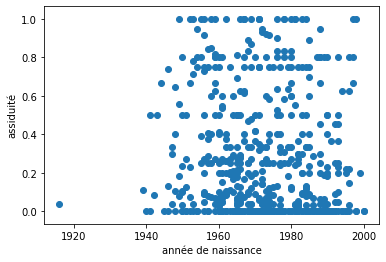

In [17]:
plt.scatter(ages,assiduity)
plt.xlabel('année de naissance')
plt.ylabel("assiduité")

Effectivement, la valeur de la corrélation semble cohérente avec l'éparpillement des données observées ici. Ainsi, l'utilisation répétée par semaine de l'application ne semble pas être dû à l'âge de l'utilisateur. Cependant, nous devons prendre en compte que certaines personnes ont acheté la licence il y a une semaine ou 2, et par conséquent ils ont tendance à profiter de leur abonnement au début de leur achat, avant de se détacher de la thérapie. Ceci explique donc la nombre important de personnes à 1.



Notons que cette définition de l'assiduité n'était peut être pas assez précise pour être explicative. Précisons là donc : 

<div class="alert alert-info"><h4>Note</h4><p>Nous appelerons maintenant assiduité 'totale', la somme du temps passé par un individu sur une thérapie depuis l'achat de sa licence, divisé par la somme des objectifs fixés par l'application. De plus, nous distinguons maintenant les 4 thérapies, chaque individu aura donc 4 scores d'assiduité.</p></div>

In [18]:
assiduité_par_individu=[]
awp=allweeklyprogressions()
for indiv in awp:
    trt=0
    objtrt=0
    cbt=0
    objcbt=0
    relax=0
    objrelax=0
    resiIn=0
    objresiIn=0
    for t in indiv:
        try:
            trt+=t["trt"][1]
            objtrt+=t["trt"][0]
        except KeyError:
            trt+=0
        try:
            cbt+=t["cbt"][1]
            objcbt+=t["cbt"][0]
        except KeyError:
            cbt+=0
        try:
            relax+=t["relaxation"][1]
            objrelax+=t["relaxation"][0]
        except KeyError:
            relax+=0
        try:
            resiIn+=t["residualInhibition"][1]
            objresiIn+=t["residualInhibition"][0]
        except KeyError:
            resiIn+=0
    if objtrt==objcbt==objrelax==objresiIn==0:
        trt=0
        cbt=0
        relax=0
        resiIn=0
        objtrt=1
        objcbt=1
        objrelax=1
        objresiIn=1
        
    if objtrt==0:
        objtrt=1
        trt=1
    if objcbt==0:
        objcbt=1
        cbt=1
    if objrelax==0:
        objrelax=1
        relax=1
    if objresiIn==0:
        objresiIn=1
        resiIn=1
    assiduité_par_individu.append({'trt': trt/objtrt, 'cbt':cbt/objcbt, "relaxation":relax/objrelax, "residualInhibition":resiIn/objresiIn})
        
print(assiduité_par_individu)
    
    

[{'trt': 0.0, 'cbt': 0.0, 'relaxation': 0.0, 'residualInhibition': 0.0}, {'trt': 0.0, 'cbt': 0.0, 'relaxation': 0.0, 'residualInhibition': 0.0}, {'trt': 0.0, 'cbt': 0.0, 'relaxation': 0.0, 'residualInhibition': 0.0}, {'trt': 0.0, 'cbt': 0.0, 'relaxation': 0.0, 'residualInhibition': 0.0}, {'trt': 0.0, 'cbt': 0.0, 'relaxation': 0.0, 'residualInhibition': 0.0}, {'trt': 0.0, 'cbt': 0.0, 'relaxation': 0.0, 'residualInhibition': 0.0}, {'trt': 0.0, 'cbt': 0.0, 'relaxation': 0.0, 'residualInhibition': 0.0}, {'trt': 0.0, 'cbt': 0.0, 'relaxation': 0.0, 'residualInhibition': 0.0}, {'trt': 0.0, 'cbt': 0.0, 'relaxation': 0.0, 'residualInhibition': 0.0}, {'trt': 0.0, 'cbt': 0.0, 'relaxation': 0.0, 'residualInhibition': 0.0}, {'trt': 0.0, 'cbt': 0.0, 'relaxation': 0.0, 'residualInhibition': 0.0}, {'trt': 0.0, 'cbt': 0.0, 'relaxation': 0.0, 'residualInhibition': 0.0}, {'trt': 0.0, 'cbt': 0.0, 'relaxation': 0.0, 'residualInhibition': 0.0}, {'trt': 0.0, 'cbt': 0.0, 'relaxation': 0.0, 'residualInhibition

Ici, si un utilisateur fait une thérapie qui n'apparaissait pas dans ses objectifs, on lui accorde systématiquement une assiduité de 100% sur cette thérapie. Un utilisateur qui n'a jamais ouvert l'application depuis son inscription a une assiduité de 0.

In [19]:
trt_par_indiv=[i["trt"] for i in assiduité_par_individu]
cbt_par_indiv=[i["cbt"] for i in assiduité_par_individu]
relax_par_indiv=[i["relaxation"] for i in assiduité_par_individu]
residualIn_par_indiv=[i["residualInhibition"] for i in assiduité_par_individu]


In [20]:
aggregated_licenses_cursor = licenses_collection.aggregate(pipeline=
        [
            {
                '$lookup': {
                    'from': 'users',
                    'localField': 'user',
                    'foreignField': '_id',
                    'as': 'user_document'
                }
            },
            {
                '$unwind' : '$user_document'
            },
            {
                '$project': {
                    '_id':0,
                    'user':'$user',
                    'activationDate':'$activationDate',
                    'birthDate':'$user_document.birthDate'
                }
            }

        ]
    )

test=[]
for user in aggregated_licenses_cursor:
    #prettyprint(user)
    test.append(user)

indices=[]
for i in range(len(test)) :
    if 'birthDate' in test[i].keys():
         indices.append(i)
print('seulement '+str(len(indices))+' utilisateurs licenciés ont renseigné leur date de naissance')

seulement 563 utilisateurs licenciés ont renseigné leur date de naissance


In [21]:
ages=[]
trt_i=[]
cbt_i=[]
relax_i=[]
resiIn_i=[]
for i in indices :
    ages.append(test[i]["birthDate"].year)
    trt_i.append(trt_par_indiv[i])
    cbt_i.append(cbt_par_indiv[i])
    relax_i.append(relax_par_indiv[i])
    resiIn_i.append(residualIn_par_indiv[i])

Text(0, 0.5, "complétion sur l'ensemble des semaines")

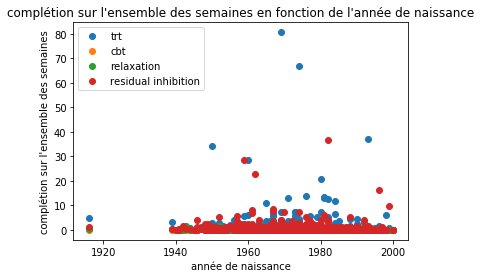

In [23]:
plt.plot(ages,trt_i, "o",label='trt')
plt.plot(ages, cbt_i, "o",label='cbt')
plt.plot(ages,relax_i,"o",label='relaxation')
plt.plot(ages,resiIn_i,"o",label="residual inhibition")
plt.legend()
plt.title("complétion sur l'ensemble des semaines en fonction de l'année de naissance")
plt.xlabel('année de naissance')
plt.ylabel("complétion sur l'ensemble des semaines")

Ce graphe est assez surprenant au premier abord car les valeurs semblent entassées en bas du graphe. Mais ceci est tout à fait normal. En effet, les données "intuitives" sont celles qui sont sensées se situer entre 0 et 1, c'est-à-dire que les utilisateurs ont complété leur objectif s'il a la valeur 1. Pourtant, on remarque que de nombreuses valeurs se situent entre 1 et 5, car certains utilisateurs préfèrent dépasser leur objectif volontairement, ou restent tout simplement dans l'application pendant plusieurs heures car ils apprécient une thérapie en particulier. Le point à 80 signifie donc qu'une personne a dépassé de 80 fois l'objectif de la trt qui lui était assigné ! Malgré tout, le lien entre l'âge et les thérapies semble très flou.

Calculons numériquement la corrélation entre l'âge et les différentes thérapies.

In [24]:
np.corrcoef(ages,trt_i)

array([[ 1.        , -0.01132728],
       [-0.01132728,  1.        ]])

In [25]:
np.corrcoef(ages,cbt_i)

array([[ 1.        , -0.15707975],
       [-0.15707975,  1.        ]])

In [26]:
np.corrcoef(ages,relax_i)

array([[ 1.        , -0.17791655],
       [-0.17791655,  1.        ]])

In [27]:
np.corrcoef(ages,resiIn_i)

array([[ 1.        , -0.03560504],
       [-0.03560504,  1.        ]])

Comme le graphique semblait le montrer, on voit que l'âge et les taux de complétion sont très peu corrélés, on remarque cependant une corrélation un peu plus élevé, (environ -0.15) pour la relaxation et cbt. Le comportement sur ces thérapies est donc peut-être légèrement corrélé avec l'âge, remarquons d'ailleurs que nous ne pouvions pas voir ces points sur le graphe précédents car ils avaient des valeurs trop faibles. Essayons donc de ne représenter que celles-ci.

Text(0, 0.5, "complétion sur l'ensemble des semaines")

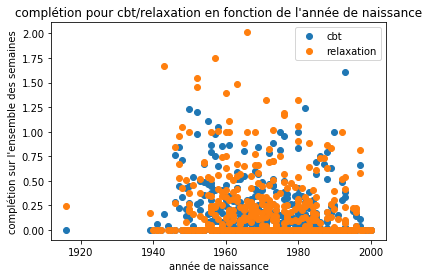

In [29]:
plt.plot(ages, cbt_i, "o",label='cbt')
plt.plot(ages,relax_i,"o",label='relaxation')
plt.legend()
plt.title("complétion pour cbt/relaxation en fonction de l'année de naissance")
plt.xlabel('année de naissance')
plt.ylabel("complétion sur l'ensemble des semaines")

Finalement, on constate une légère baisse en relaxation, mais les points semblent tout de même assez peu influencés par l'âge.
Aussi, nous n'avons pas filtré l'année 1965, année de naissance par défaut, afin de ne pas avoir de "trou" dans le graphique, cependant, le fait qu'on ne constate pas de discontinuité à cette date, appuie encore plus le fait que l'âge et l'assiduité ne sont pas (ou très peu) corrélés.

### Conclusion

On déduit des résultats précédents une très faible (voire une absence) de corrélation entre l'âge de l'utilisateur et l'assiduité aux différentes thérapies. Malgré tout, nous tirons quelques informations intéressantes, comme le fait que certains utilisateurs complètent (largement) l'objectif qui leur est assigné et cela volontairement, très certainement. Aussi, beaucoup d'utilisateurs de tout âge ont tendance à remplir leurs objectifs les 2 premières semaines après leur inscription, car ils veulent profiter de l'abonnement récemment acheté.

## Existe-il un lien entre la nuisance de l’acouphène et l’assiduité à la thérapie ?

L'engagement de l’utilisateur de l'application peut a priori être corrélé à la nuisance de son acouphène. On pourrait croire que les personnes qui souffrent le plus seraient plus motivées à remplir tous les objectifs pour espérer avoir de bons résultats et baisser la nuisance de leur acouphène. 

L'application propose quelques évaluations sous forme de questions sur des aspects de la vie quotidienne pour mesurer à quel point l'acouphène est embêtant. 
Une première évaluation est le questionnaire hebdomadaire "wfu" sous forme de 8 questions (donc 8 sous-scores) et qui renvoie un score total compris entre 0 (acouphène pas du tout nuisible) et 80 (acouphène sévère et très gênant dans la vie de tous les jours). 

Nous nous intéressons dans un premier temps à cette évaluation et on cherche à trouver une corrélation entre les scores obtenus par les utilisateurs et leur assiduité. 

<div class="alert alert-info"><h4>Définition de l'assiduité : </h4><p>On définit ici l'assiduité pour un utilisateur comme l'évolution du taux de complétion des objectifs hebdomadaires, au fil des semaines.

$ Taux\,de\, complétion\, des\, objectifs\, hebdomadaires = \frac{temps\, passé\, sur\, les\, 4\, thérapies}{objectifs\, totaux} $

On parlera abusivement d'assiduité sur une seule semaine, pour parler du taux de complétion des objectifs hebdomadaires relatif à cette semaine.</p></div>

#### Observations de l'assiduité en fonction du score global :

On commence par récupérer les données des utilisateurs qui ont déjà fait l'évaluation "wfu" au moins une fois et dont le score est réellement significatif (i.e pas de réponses par défaut), et uniquement ceux qui ont souscris à une licence. 

In [31]:
#on recupere les scores wfu des utilisateurs
def user_evaluation_wfu_list(user):
    evaluation_cursor = events_collection.find({'type': 'ACTIVITY_COMPLETE','data.name': 'wfu',
                                                'user':user,'data.activity':'evaluation', 
                                                "$or":[{'data.subScores.intensity': {'$ne': 5}},
                                                        {'data.subScores.control': {'$ne': 5}},
                                                      {'data.subScores.concentration': {'$ne': 5}},
                                                        {'data.subScores.sleep': {'$ne': 5}},
                                                        {'data.subScores.auditive': {'$ne': 5}},
                                                        {'data.subScores.relaxation': {'$ne': 5}},
                                                        {'data.subScores.mood': {'$ne': 5}},
                                                        {'data.subScores.serenity': {'$ne': 5}} ]},
                                               {"_id":0,'date':1, 'data.subScores':1,'data.score':1}
                                                         )
    evaluation_list = []
    for evaluation in evaluation_cursor:
        evaluation_list += [evaluation]
        
        
    return evaluation_list

In [32]:
#dictionnaire des evaluations wfu pour tous les users avec une licence
users_evaluation_wfu_dict = {}
for license in licenses_collection.find({}):
    user = license['user']
    users_evaluation_wfu_dict[user] = user_evaluation_wfu_list(user)

In [33]:
#on élimine les users dont le dictionnaire décrivant les évaluations wfu est vide

users_evaluation_wfu_dict_clean = {}
for user in users_evaluation_wfu_dict:
    if users_evaluation_wfu_dict[user] :
        users_evaluation_wfu_dict_clean[user] = users_evaluation_wfu_dict[user]
print('On garde '+str(len(users_evaluation_wfu_dict_clean))+ 'utilisateurs')
# 558

On garde 558utilisateurs


In [34]:

sum = 0
for user in users_evaluation_wfu_dict_clean:
    sum +=len(users_evaluation_wfu_dict_clean[user])
print('On a '+str(sum)+' évaluations wfu en total sur la bdd')

#On a 2100 évaluations wfu en total sur la bbd


On a 2100 évaluations wfu en total sur la bdd


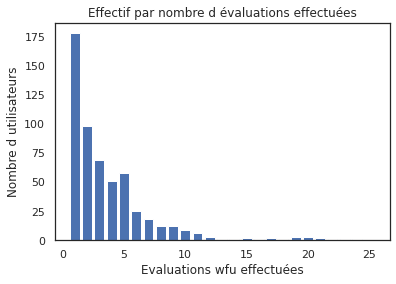

In [35]:
# visualise la distribution du nombre de users ayant effectuer le même  nombre d'évaluations wfu
count_eval = {}
for user in users_evaluation_wfu_dict_clean:
    n = len(users_evaluation_wfu_dict_clean[user])
    if n in count_eval:
        count_eval[n] += 1
    else:
        count_eval[n] = 1
X = [i for i in range(1,26)]
Y = [0 for i in range(25)]
for i in X:
    if i in count_eval:
        Y[i-1] = count_eval[i]

plt.bar(X,Y)
plt.xlabel('Evaluations wfu effectuées')
plt.ylabel('Nombre d utilisateurs')
plt.title('Effectif par nombre d évaluations effectuées')
plt.show()

Après une première visualisation des données; on constate qu'on fait l'étude juste sur 558 des 755 utilisateurs qui ont une licence, en ne gardant que ceux qui ont répondu au moins sur un questionnaire wfu sans laisser les valeurs par défaut sur les 8 questions. On constate aussi que le nombre d’évaluations effectuées enregistré sur events est 2100. La majorité des patients ont répondu 1 à 5 fois au questionnaire wfu pendant leur période d'utilisation de l'application. Comme on n'a pas assez de résultats des questionnaires wfu pour tous les patients, ce qui pourrait être justifié par exemple par la date à partir de laquelle un certain utilisateur a commencé son activité sur l'application, on a décidé d'évaluer l'influence du score qu'un utilisateur de l'application obtient suite au questionnaire wfu sur son assiduité la semaine qui suit.  

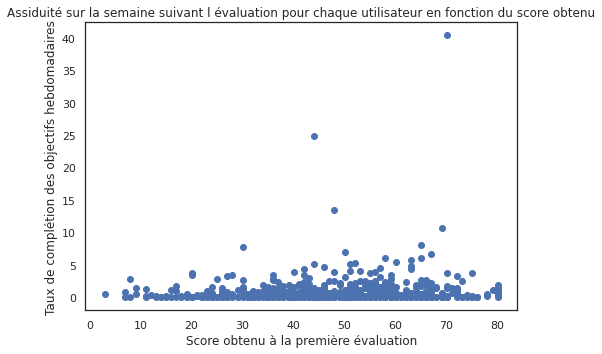

In [36]:

fig=plt.figure()
ax=fig.add_axes([0,0,1,1])

for user in users_evaluation_wfu_dict_clean:
    Y_S_user = []
    X_S_user = []
    
    date = users_evaluation_wfu_dict_clean[user][0]['date']
    score = users_evaluation_wfu_dict_clean[user][0]['data']['score']
    d = progression_par_semaine(user,date)[0]
    if d : # ils ont des activites
        sum_obj = 0
        sum_prog = 0
        for key in d:
                
            try:
                sum_obj += d[key][0]
                sum_prog += d[key][1]
                taux = sum_prog / sum_obj
            except:
                taux = 0
                
                    
        X_S_user += [score]
        Y_S_user += [taux]
    ax.scatter(X_S_user,Y_S_user, color = 'b')
    ax.set_xlabel('Score obtenu à la première évaluation')
    ax.set_ylabel('Taux de complétion des objectifs hebdomadaires')
    ax.set_title('Assiduité sur la semaine suivant l évaluation pour chaque utilisateur en fonction du score obtenu')

On remarque donc ici que la plupart des points sont concentrés dans l'intervalle [0,5]. Et à cause de quelques points parasites (utilisateurs faisant 40 fois plus que l'objectif prescrit par l'application), on a du mal à observer une tendance. On va donc moyenner le taux de complétion des objectifs pour les utilisateurs ayant le même score pour réduire le nombre de points et faciliter la lecture.

In [37]:
# l'evolution de l'assiduite suite a la premiere evaluation de chaque user wfu
X_S = [i for i in range(0,81)] #score global
dict_S = {}
for i in X_S:
    dict_S[i] = []

for user in users_evaluation_wfu_dict_clean:
    date = users_evaluation_wfu_dict_clean[user][0]['date']
    score = users_evaluation_wfu_dict_clean[user][0]['data']['score']
    d = progression_par_semaine(user,date)[0]
    if d:
        sum_obj = 0
        sum_prog = 0
        for key in d:
            sum_obj += d[key][0]
            sum_prog += d[key][1]
        taux = sum_prog / sum_obj
    dict_S[score] += [taux]   
    #else:
        #taux = 0
    #dict_S[score] += [taux]

Y_S = [0 for i in range(0,81)]
for i in range(81):
    if dict_S[i]:
        Y_S[i] = np.sum(dict_S[i]) / len(dict_S[i])
# print(len(dict_S[1]))

Text(0.5, 1.0, 'Assiduité moyenne sur la semaine suivant l évaluation pour tous les utilisateurs ayant obtenu le même score')

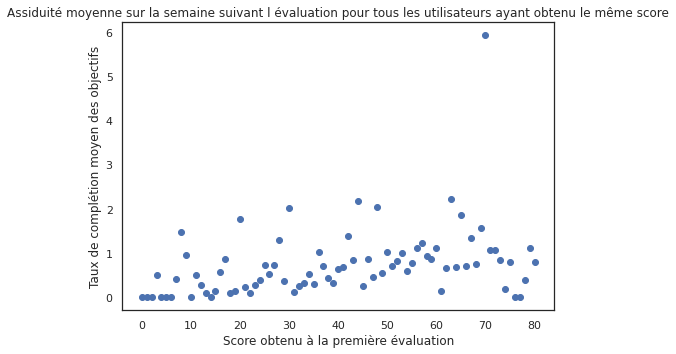

In [38]:
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(X_S, Y_S, color='b')
ax.set_xlabel('Score obtenu à la première évaluation')
ax.set_ylabel('Taux de complétion moyen des objectifs')
ax.set_title('Assiduité moyenne sur la semaine suivant l évaluation pour tous les utilisateurs ayant obtenu le même score')

Le graphe obtenu en moyennant les assiduités est plus lisible et nous permet de lire des choses intéressantes. On voit par exemple que l'assiduité moyenne est faible et à peu près la même sur l'intervalle [0,15] des scores, mais à partir du score 20 environ, on remarque que l'assiduité moyenne a tendance à augmenter avec le score, jusqu'à une valeur du score égale à 60 où  elle commence à décroître avec le score. Cette dernière variation est contre intuitive, on va donc essayer d'aborder le problème avec beaucoup plus de données. 

In [39]:
# on évalue la correaltion du premier score obtenu de wfu sur l'assiduite dans la semaine qui suit
np.corrcoef(X_S, Y_S)

array([[1.        , 0.35613859],
       [0.35613859, 1.        ]])

 On constate qu'il y a une corrélation considérable entre le score global sur la première évaluation wfu et l'assiduité sur la semaine suivante.

Jusque là, nous n'avons considéré pour chaque utilisateur que la première évaluation. Nous allons considérer à présent que les évaluations suivantes (pour les utilisateurs qui en ont fait plusieurs) correspondent à de nouveaux utilisateurs, pour avoir une meilleure représentation de l'assiduité de la semaine suivant l'évaluation. ON refait donc la même démarche qu'avant mais pour une semi-nouvelle base d'utilisateurs.

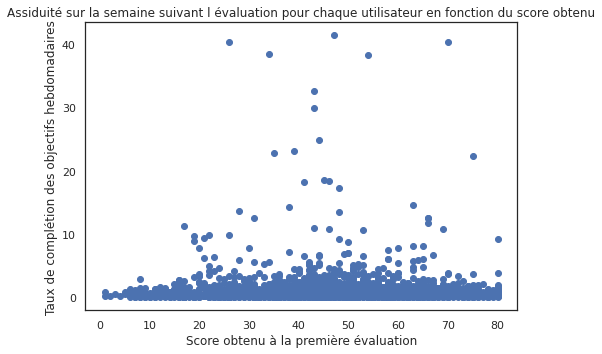

In [40]:
#On considere que a chaque nouvelle evaluation le 'user' se comporte comme si c'etait la premiere evaluation
##on evalue l'assiduité dans la semaine qui suit chaque evaluation pour chaque user 
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])

for user in users_evaluation_wfu_dict_clean:
    Y_S_user = []
    X_S_user = []
    for i in range(len(users_evaluation_wfu_dict_clean[user])):
        date = users_evaluation_wfu_dict_clean[user][i]['date']
        score = users_evaluation_wfu_dict_clean[user][i]['data']['score']
        d = progression_par_semaine(user,date)[0]
        if d : # ils ont des activites
            sum_obj = 0
            sum_prog = 0
            for key in d:
                try:
                    sum_obj += d[key][0]
                    sum_prog += d[key][1]
                    taux = sum_prog / sum_obj
                except:
                    continue
                    
            X_S_user += [score]
            Y_S_user += [taux]
    ax.scatter(X_S_user,Y_S_user, color = 'b')
    ax.set_xlabel('Score obtenu à la première évaluation')
    ax.set_ylabel('Taux de complétion des objectifs hebdomadaires')
    ax.set_title('Assiduité sur la semaine suivant l évaluation pour chaque utilisateur en fonction du score obtenu')

Là encore, on peut voir que le plus gros nuage de points s'étend sur l'intervalle [0,5] de l'assiduité et on retrouve les valeurs d'assiduité les plus importantes de ce nuage pour des scores allant de 38 à 55 environ. Par contre, on a toujours du mal à observer les tendances que pourraient avoir l'assiduité à cause des points parasites (utilisateurs faisant 20,30,40 fois plus que l'objectif prescrit par l'application), et aussi à cause du grand nombre de points.
On va donc procéder comme à l'étape précédente et moyenner le taux de complétion des objectifs pour les utilisateurs ayant le même score.

In [41]:
#on evalue l'assiduité dans la semaine qui suit chaque evaluation
X_S_total = [i for i in range(0,81)] #score global
dict_S_total = {}
for i in X_S_total:
    dict_S_total[i] = []

for user in users_evaluation_wfu_dict_clean:
    
    for i in range(len(users_evaluation_wfu_dict_clean[user])):
        date = users_evaluation_wfu_dict_clean[user][i]['date']
        score = users_evaluation_wfu_dict_clean[user][i]['data']['score']
        d = progression_par_semaine(user,date)[0] # la semaine apres l'evaluation
        if d:# s'il a  un prog a faire au cours de la semaine
            sum_obj = 0
            sum_prog = 0
            for key in d:
                try:
                    sum_obj += d[key][0]
                    sum_prog += d[key][1]
                    taux = sum_prog / sum_obj
                except:
                    taux = 1
        dict_S_total[score] += [taux]       
        #else:
            #taux = 0
        #dict_S_total[score] += [taux]
Y_S_total = [0 for i in range(0,81)]
for i in range(81):
    if dict_S_total[i]:
        Y_S_total[i] = np.sum(dict_S_total[i]) / len(dict_S_total[i])

Text(0.5, 1.0, 'Assiduité moyenne sur la semaine suivant l évaluation pour tous les utilisateurs ayant obtenu le même score')

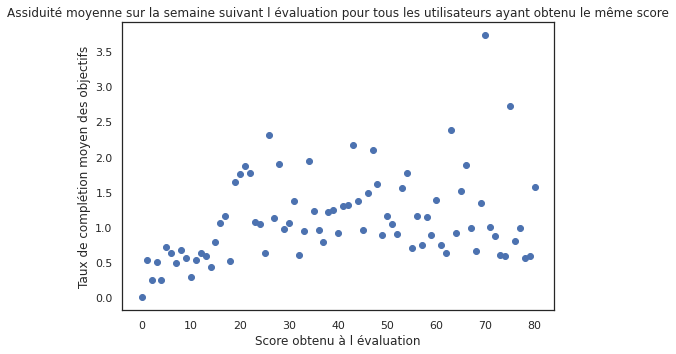

In [42]:
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(X_S_total, Y_S_total, color='b')
ax.set_xlabel('Score obtenu à l évaluation')
ax.set_ylabel('Taux de complétion moyen des objectifs')
ax.set_title('Assiduité moyenne sur la semaine suivant l évaluation pour tous les utilisateurs ayant obtenu le même score')

Ce graphe est beaucoup plus lisible et confirme à peu près les mêmes résultats qu'avant (obtenus en considérant juste la première évaluation de chaque utilisateur).  
Pour des scores de 0 à 15, l'assiduité moyenne est faible. A partir du score 15 environ, l'assiduité moyenne augmente avec le score, jusqu'à une valeur du score égale à 60 où  elle comemence à baisser. Pour des scores entre 65 et 80, l'assiduité moyenne fluctue considérablement mais se voit surtout à la baisse. Encore une fois, ce n'était pas le résultat attendu.
On va regarder donc de plus près ces utilisateurs pour chaque tranche de scores différente.

In [43]:
#on evalue la correlation entre le score et l'assiduite dans la semaine qui suit
np.corrcoef(X_S_total, Y_S_total)

array([[1.        , 0.32047577],
       [0.32047577, 1.        ]])

On remarque ici que la corrélation entre score globale et assiduité sur la semaine suivante pour tout les résultats des questionnaires wfu remplis est à peu près la même que pour le cas avec uniquement la première évaluation qui est prise en compte. 

##### Observation de l'assiduité pour des classes d'utilisateurs

<div class="alert alert-info"><h4>Regroupement des utilisateurs en 4 clusters en fonction du score wfu : </h4><p>

En fonction des observations précédentes, on va définir 4 niveaux de nuisance différents : 
    
Acouphène très peu (voire pas du tout) nuisible : $ score \in [0,15] $ 
    
Acouphène peu nuisible : $ score \in [15,40] $ 
    
Acouphène moyennement nuisible : $ score \in [40,60] $ 
    
Acouphène très nuisible : $ score \in [60,80] $ 
  
On observera l'assiduité sur 30 semaines moyennée sur ces groupes d'utilisateurs.</p></div>

On prend uniquement le score obtenu à la première évaluation, on supposera que le score n'évolue pas énormément (car nous ne pouvons pas suivre son évolution étant donné le nombre faible de personnes qui prennent la peine de faire l'évaluation wfu plusieurs fois), et on observe l'assiduité moyenne sur 30 semaines d'utilisation. On considère que la première semaine pour un utilisateur lambda correspond à la semaine juste après sa souscription à la licence. 

On a 15 utilisateurs avec une très faible nuisance d acouphène, 147 avec une faible nuisance, 272 avec une moyenne nuisance et 124 personnes avec une grande nuisance. 

On a donc 558 utilisateurs qui ont fait au moins une fois l évaluation wfu. 

Ces différentes classes représentent les différents cohortes sur lesquelles on va observer l assiduité.


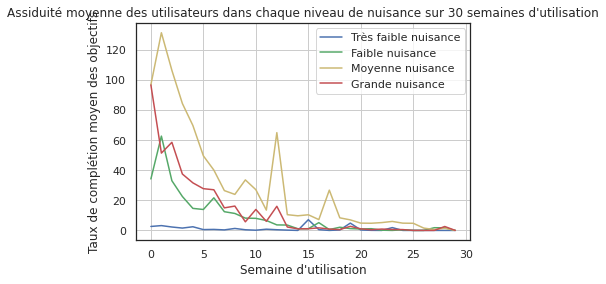

In [44]:
# dictionnaires des users classés en fonction de la nuisance en se basant sur le score de leur 1ère évaluation wfu
users_eval_wfu_clean_ntresfaible_dict = {}
users_eval_wfu_clean_nfaible_dict = {}
users_eval_wfu_clean_nmoyenne_dict = {}
users_eval_wfu_clean_ngrande_dict = {}

sum_ntresfaible = 0
sum_nfaible = 0
sum_nmoyenne = 0
sum_ngrande = 0

for user in users_evaluation_wfu_dict_clean:
    if users_evaluation_wfu_dict_clean[user][0]['data']['score'] < 15 and users_evaluation_wfu_dict_clean[user][0]['data']['score'] >= 0 :
        users_eval_wfu_clean_ntresfaible_dict[user] = users_evaluation_wfu_dict_clean[user]
        sum_ntresfaible += 1
    if users_evaluation_wfu_dict_clean[user][0]['data']['score'] < 40 and users_evaluation_wfu_dict_clean[user][0]['data']['score'] >= 15 :
        users_eval_wfu_clean_nfaible_dict[user] = users_evaluation_wfu_dict_clean[user]
        sum_nfaible += 1
    if users_evaluation_wfu_dict_clean[user][0]['data']['score'] < 60 and users_evaluation_wfu_dict_clean[user][0]['data']['score'] >= 40 :
        users_eval_wfu_clean_nmoyenne_dict[user] = users_evaluation_wfu_dict_clean[user]
        sum_nmoyenne += 1
    if users_evaluation_wfu_dict_clean[user][0]['data']['score'] >= 60 :
        users_eval_wfu_clean_ngrande_dict[user] = users_evaluation_wfu_dict_clean[user]
        sum_ngrande += 1
    
print('On a '+str(sum_ntresfaible)+' utilisateurs avec une très faible nuisance d acouphène, '+str(sum_nfaible)+' avec une faible nuisance, '+str(sum_nmoyenne)+' avec une moyenne nuisance et '+str(sum_ngrande)+' personnes avec une grande nuisance. \n\nOn a donc '+str(sum_ntresfaible + sum_nfaible + sum_nmoyenne + sum_ngrande)+' utilisateurs qui ont fait au moins une fois l évaluation wfu. \n\nCes différentes classes représentent les différents cohortes sur lesquelles on va observer l assiduité.')


##progressions des utilisateurs de chaque classe
#progressions des utilisateurs de la 1ère classe (nuisance très faible, score entre 0 et 15)
def allweeklyprogressions_ntresfaible():
    
    licenses=[]
    many_licenses_cursor=licenses_collection.find({},{"_id":0,"user":1,"activationDate":1})
    for event in many_licenses_cursor:
        licenses.append(event)

    weeklyprogressions_ntresfaible=[]
    
    for i in range(0,len(licenses)):
        user=licenses[i]['user']
        activationdate=licenses[i]['activationDate']
        
        if user in users_eval_wfu_clean_ntresfaible_dict :
            weeklyprogressions_ntresfaible.append(progression_par_semaine(user,activationdate))
    
    return(weeklyprogressions_ntresfaible)


#progressions des utilisateurs de la 2ème classe (nuisance faible, score entre 15 et 40)
def allweeklyprogressions_nfaible():
    
    licenses=[]
    many_licenses_cursor=licenses_collection.find({},{"_id":0,"user":1,"activationDate":1})
    for event in many_licenses_cursor:
        licenses.append(event)

    weeklyprogressions_nfaible=[]
    
    for i in range(0,len(licenses)):
        user=licenses[i]['user']
        activationdate=licenses[i]['activationDate']
        
        if user in users_eval_wfu_clean_nfaible_dict :
            weeklyprogressions_nfaible.append(progression_par_semaine(user,activationdate))
    
    return(weeklyprogressions_nfaible)


#progressions des utilisateurs de la 3ème classe (nuisance moyenne, score entre 40 et 60)
def allweeklyprogressions_nmoyenne():
    
    licenses=[]
    many_licenses_cursor=licenses_collection.find({},{"_id":0,"user":1,"activationDate":1})
    for event in many_licenses_cursor:
        licenses.append(event)

    weeklyprogressions_nmoyenne=[]
    
    for i in range(0,len(licenses)):
        user=licenses[i]['user']
        activationdate=licenses[i]['activationDate']
        
        if user in users_eval_wfu_clean_nmoyenne_dict :
            weeklyprogressions_nmoyenne.append(progression_par_semaine(user,activationdate))
    
    return(weeklyprogressions_nmoyenne)


#progressions des utilisateurs de la 4ème classe (grande nuisance, score entre 60 et 80)
def allweeklyprogressions_ngrande():
    
    licenses=[]
    many_licenses_cursor=licenses_collection.find({},{"_id":0,"user":1,"activationDate":1})
    for event in many_licenses_cursor:
        licenses.append(event)

    weeklyprogressions_ngrande=[]
    
    for i in range(0,len(licenses)):
        user=licenses[i]['user']
        activationdate=licenses[i]['activationDate']
        
        if user in users_eval_wfu_clean_ngrande_dict :
            weeklyprogressions_ngrande.append(progression_par_semaine(user,activationdate))
    
    return(weeklyprogressions_ngrande)




#définition des fonctions assiduité sur toutes les semaines d'utilisation
awp_ntresfaible = allweeklyprogressions_ntresfaible()
awp_nfaible = allweeklyprogressions_nfaible()
awp_nmoyenne = allweeklyprogressions_nmoyenne()
awp_ngrande = allweeklyprogressions_ngrande()

assiduité_ntresfaible=[0 for i in range(30)]
assiduité_nfaible=[0 for i in range(30)]
assiduité_nmoyenne=[0 for i in range(30)]
assiduité_ngrande=[0 for i in range(30)]

x = len(awp_ntresfaible)
y = len(awp_nfaible)
z = len(awp_nmoyenne)
t = len(awp_ngrande)

for i in range(x):
    p=len(awp_ntresfaible[i])
    for j in range(min(p,30)):
        if awp_ntresfaible[i][j]:
            res = awp_ntresfaible[i][j]['trt'][1]+awp_ntresfaible[i][j]['cbt'][1]+awp_ntresfaible[i][j]['relaxation'][1]+awp_ntresfaible[i][j]['residualInhibition'][1]
            obj = awp_ntresfaible[i][j]['trt'][0]+awp_ntresfaible[i][j]['cbt'][0]+awp_ntresfaible[i][j]['relaxation'][0]+awp_ntresfaible[i][j]['residualInhibition'][0]
            m = res/obj
            assiduité_ntresfaible[j]+= m/n

for i in range(y):
    p=len(awp_nfaible[i])
    for j in range(min(p,30)):
        if awp_nfaible[i][j]:
            res = awp_nfaible[i][j]['trt'][1]+awp_nfaible[i][j]['cbt'][1]+awp_nfaible[i][j]['relaxation'][1]+awp_nfaible[i][j]['residualInhibition'][1]
            obj = awp_nfaible[i][j]['trt'][0]+awp_nfaible[i][j]['cbt'][0]+awp_nfaible[i][j]['relaxation'][0]+awp_nfaible[i][j]['residualInhibition'][0]
            m = res/obj
            assiduité_nfaible[j]+= m/n

for i in range(z):
    p=len(awp_nmoyenne[i])
    for j in range(min(p,30)):
        if awp_nmoyenne[i][j]:
            res = awp_nmoyenne[i][j]['trt'][1]+awp_nmoyenne[i][j]['cbt'][1]+awp_nmoyenne[i][j]['relaxation'][1]+awp_nmoyenne[i][j]['residualInhibition'][1]
            obj = awp_nmoyenne[i][j]['trt'][0]+awp_nmoyenne[i][j]['cbt'][0]+awp_nmoyenne[i][j]['relaxation'][0]+awp_nmoyenne[i][j]['residualInhibition'][0]
            m = res/obj
            assiduité_nmoyenne[j]+= m/n

for i in range(t):
    p=len(awp_ngrande[i])
    for j in range(min(p,30)):
        if awp_ngrande[i][j]:
            res = awp_ngrande[i][j]['trt'][1]+awp_ngrande[i][j]['cbt'][1]+awp_ngrande[i][j]['relaxation'][1]+awp_ngrande[i][j]['residualInhibition'][1]
            obj = awp_ngrande[i][j]['trt'][0]+awp_ngrande[i][j]['cbt'][0]+awp_ngrande[i][j]['relaxation'][0]+awp_ngrande[i][j]['residualInhibition'][0]
            m = res/obj
            assiduité_ngrande[j]+= m/n


#graphe d'assiduité au fil des semaines d'utilisation en se basant sur le score wfu 
Semaines = [i for i in range(30)]
plt.plot(Semaines ,assiduité_ntresfaible,'b-',label='Très faible nuisance')
plt.plot(Semaines ,assiduité_nfaible,'g-',label='Faible nuisance')
plt.plot(Semaines ,assiduité_nmoyenne,'y-',label='Moyenne nuisance')
plt.plot(Semaines ,assiduité_ngrande,'r-',label='Grande nuisance')
plt.xlabel("Semaine d'utilisation")
plt.ylabel("Taux de complétion moyen des objectifs")
plt.title("Assiduité moyenne des utilisateurs dans chaque niveau de nuisance sur 30 semaines d'utilisation")
plt.grid()
plt.legend(loc=0)
plt.show()

On voit bien que la classe d'utilisateurs avec une très faible nuisance de l'acouphène ne remplit presque pas les objectifs en moyenne : c'est compréhensible et c'était prévisible au vu des résultats précédents.
Pour les classes avec une faible à moyenne nuisance de l'acouphène (correspondant à des scores entre 15 et 60), les objectifs sont largement remplis en moyenne jusqu'aux semaines 10-15 d'utilisation. 
On remarque notamment que la classe à moyenne nuisance de l'acouphène est très assidue jusqu'à la semaine 15 environ, après la chute d'assiduité est normale et déjà démontrée avant; les utilisateurs sont plus engagés au début puis la motivation se voit à la baisse au fil des semaines.
La courbe la plus étrange (mais qui correspond bien à ce qu'on avait remarqué avant) est celle de la classe à grande nuisance de l'acouphène qui a une une moins bonne assiduité moyenne que la classe à moyenne nuisance. Cette courbe est étrange car on s'attend à ce que cette classe (qui a un score entre 60 et 80 et qui souffre donc le plus des acouphènes) soit la plus assidue et engagée.

On peut donc expliquer ce résultat qui contredit nos attentes par une démotivation rapide des personnes souffrantes et qui sont donc plus amenées à être anxieuses et inquiètes, elles perdent peut-être rapidement l'espoir d'un rétablissement possible. 
On pourrait donc penser à un accompagnement psychologique qui viendrait compléter la thérapie de ces utilisateurs, pour les aider à remplir leurs objectifs et ne pas se décourager.

#### Observation de l'assiduité en fonction des sous-scores : 

On évalue cette fois-ci l'influence que peut avoir chaque sous score correspondant à l'une des 8 questions sur l'assiduité dans la semaine qui suit l'enregistrement des réponses sur un questionnaire. Jusqu'ici on a travaillé uniquement avec la moyenne des assiduités sur tous les patients ayant obtenu un même score global.
On examine d'abord les corrélations entre ces différents sous-scores.
 

In [45]:
# On descend vers les subscores
#On évalue la corrélation entre les différents subscores ie entre les 8 critères du questionnaire de wfu
Score_intensity = []
Score_control = []
Score_concentration = []
Score_sleep = []
Score_auditive = []
Score_relaxation = []
Score_mood = []
Score_serenity = []
for user in users_evaluation_wfu_dict_clean:
    for i in range(len(users_evaluation_wfu_dict_clean[user])):
        Score_intensity += [users_evaluation_wfu_dict_clean[user][i]['data']['subScores']['intensity']]
        Score_control += [users_evaluation_wfu_dict_clean[user][i]['data']['subScores']['control']]
        Score_concentration += [users_evaluation_wfu_dict_clean[user][i]['data']['subScores']['concentration']]
        Score_sleep += [users_evaluation_wfu_dict_clean[user][i]['data']['subScores']['sleep']]
        Score_auditive += [users_evaluation_wfu_dict_clean[user][i]['data']['subScores']['auditive']]
        Score_relaxation += [users_evaluation_wfu_dict_clean[user][i]['data']['subScores']['relaxation']]
        Score_mood += [users_evaluation_wfu_dict_clean[user][i]['data']['subScores']['mood']]
        Score_serenity += [users_evaluation_wfu_dict_clean[user][i]['data']['subScores']['serenity']]

In [46]:
#On visualise eb matrice les correlations entre les criteres d'eval wfu

df = pd.DataFrame({'intensity ':Score_intensity })
df['control'] = Score_control
df['concentration'] = Score_concentration
df['sleep'] = Score_sleep
df['auditive'] = Score_auditive 
df['relaxation'] = Score_relaxation
df['mood'] = Score_mood
df['serenity'] = Score_serenity

df.corr()

,intensity,control,concentration,sleep,auditive,relaxation,mood,serenity
intensity,1.000000,0.744684,0.606439,0.473033,0.508927,0.579102,0.594050,0.519692
control,0.744684,1.000000,0.680480,0.528859,0.511388,0.649188,0.674474,0.601660
concentration,0.606439,0.680480,1.000000,0.549557,0.583802,0.686794,0.734090,0.650188
sleep,0.473033,0.528859,0.549557,1.000000,0.318444,0.627847,0.572035,0.619506
auditive,0.508927,0.511388,0.583802,0.318444,1.000000,0.460182,0.541301,0.384436
relaxation,0.579102,0.649188,0.686794,0.627847,0.460182,1.000000,0.784795,0.685750
mood,0.594050,0.674474,0.734090,0.572035,0.541301,0.784795,1.000000,0.737520
serenity,0.519692,0.601660,0.650188,0.619506,0.384436,0.685750,0.737520,1.000000


Corrélations entre les critères d'évaluation wfu


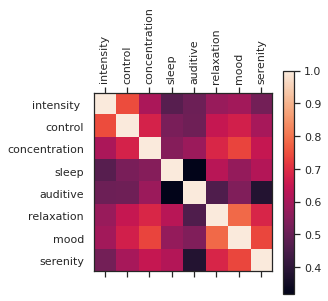

In [61]:
#On visualise les correlations entre les criteres d'eval wfu
plt.matshow(df.corr())
plt.xticks(range(len(df.columns)), df.columns, rotation = 90)
plt.yticks(range(len(df.columns)), df.columns)
plt.colorbar()
print ("Corrélations entre les critères d'évaluation wfu")
plt.show()

On remarque que les 8 critères de l’évaluation wfu sont globalement corrélées entre eux: On s'attend donc a ce que leur influence sur l’assiduité soit comparable.

Examinons maintenant de plus près l'influence que peut avoir la présence de patients qui leur activité sur les thérapies peut faire jusqu'à 40 fois les objectifs que l'application leur a recommandé.

In [48]:
#on evalue l'influence de chaque critere d'evaluation wfu en particulier sur l'assiduité dans la semaine qui suit en utilisant la métrique de la moyenne
def res_subscore_moy(subscore):
    
    X_S_subscore = [i for i in range(0,11)] #score global
    dict_S_subscore = {}
    for i in X_S_subscore:
        dict_S_subscore[i] = []
    for user in users_evaluation_wfu_dict_clean:
        for i in range(len(users_evaluation_wfu_dict_clean[user])):
            date = users_evaluation_wfu_dict_clean[user][i]['date']
            score = users_evaluation_wfu_dict_clean[user][i]['data']['subScores'][subscore]
            d = progression_par_semaine(user,date)[0]#premiere semaine apres l'eval
            if d:
                sum_obj = 0
                sum_prog = 0
                for key in d:
                    try:
                        sum_obj += d[key][0]
                        sum_prog += d[key][1]
                        taux = sum_prog / sum_obj
                    except:
                        taux = 0 # a revoir
            else:
                taux = 0
            dict_S_subscore[score] += [taux]
    Y_S_subscore = [0 for i in range(0,11)]
    for i in range(11):
        if dict_S_subscore[i]:
            Y_S_subscore[i] = np.sum(dict_S_subscore[i]) / len(dict_S_subscore[i]) #moyenne
    return Y_S_subscore 
# retourne la liste des assiduités moy pour chaque valeur du subscore sur toutes les eval et touts les users

In [49]:
#on evalue l'influence de chaque critere d'evaluation wfu en particulier sur l'assiduité dans la semaine qui suit en utilisant la métrique de médiane
def res_subscore_mediane(subscore):
    
    X_S_subscore = [i for i in range(0,11)] #score global
    dict_S_subscore = {}
    for i in X_S_subscore:
        dict_S_subscore[i] = []
    for user in users_evaluation_wfu_dict_clean:
        for i in range(len(users_evaluation_wfu_dict_clean[user])):
            date = users_evaluation_wfu_dict_clean[user][i]['date']
            score = users_evaluation_wfu_dict_clean[user][i]['data']['subScores'][subscore]
            d = progression_par_semaine(user,date)[0]#premiere semaine apres l'eval
            if d:
                sum_obj = 0
                sum_prog = 0
                for key in d:
                    try:
                        sum_obj += d[key][0]
                        sum_prog += d[key][1]
                        taux = sum_prog / sum_obj
                    except:
                        taux = 0 
            else:
                taux = 0
            dict_S_subscore[score] += [taux]
    Y_S_subscore = [0 for i in range(0,11)]
    for i in range(11):
        if dict_S_subscore[i]:
            Y_S_subscore[i] = np.median(dict_S_subscore[i]) # mediane au lieu de moyenne
    return Y_S_subscore 
# retourne la liste des médianes des assiduites  pour chaque valeur du subscore sur toutes les eval et touts les users

In [50]:
#Avec la moyenne comme métrique 
X_S_subscore = [i for i in range(11)]
Y_S_intensity_moy = res_subscore_moy('intensity')
Y_S_control_moy = res_subscore_moy('control')
Y_S_concentration_moy = res_subscore_moy('concentration')
Y_S_sleep_moy = res_subscore_moy('sleep')
Y_S_auditive_moy = res_subscore_moy('auditive')
Y_S_relaxation_moy = res_subscore_moy('relaxation')
Y_S_mood_moy = res_subscore_moy('mood')
Y_S_serenity_moy = res_subscore_moy('serenity')

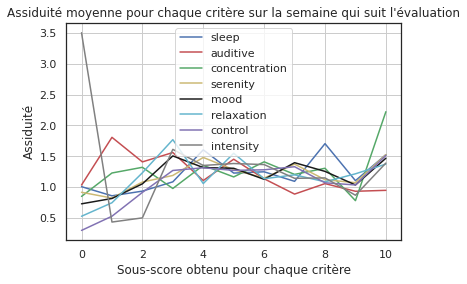

In [51]:
plt.plot(X_S_subscore, Y_S_sleep_moy, color='b',label='sleep') # les Y_S pour l'assiduite et X_S pour valeur du score
plt.plot(X_S_subscore, Y_S_auditive_moy, color='r',label='auditive')
plt.plot(X_S_subscore, Y_S_concentration_moy, color='g',label='concentration')
plt.plot(X_S_subscore, Y_S_serenity_moy, color='y',label='serenity')
plt.plot(X_S_subscore, Y_S_mood_moy, color='k',label='mood')
plt.plot(X_S_subscore, Y_S_relaxation_moy, color='c',label='relaxation')
plt.plot(X_S_subscore, Y_S_control_moy, color='m',label='control')
plt.plot(X_S_subscore, Y_S_intensity_moy, color='gray',label='intensity')
plt.grid(True)
plt.xlabel('Sous-score obtenu pour chaque critère')
plt.ylabel("Assiduité")
plt.title("Assiduité moyenne pour chaque critère sur la semaine qui suit l'évaluation")
plt.legend(loc=0)
plt.show()

On remarque en utilisant la métrique de la moyenne ,pour calculer l’assiduité correspondant à l'ensemble des patients ayant obtenu un même sous score pour une question donnée, que les variations des valeurs prises par l'assiduité selon la valeur d'un sous score donné suivent les mêmes tendances du cas du score global. On remarque aussi que pour des valeurs des 8 sous-scores entre 3 et 7, l'assiduité changent légèrement.

In [52]:
#Avec la médianne comme métrique 
X_S_subscore = [i for i in range(11)]
Y_S_intensity_mediane = res_subscore_mediane('intensity')
Y_S_control_mediane = res_subscore_mediane('control')
Y_S_concentration_mediane = res_subscore_mediane('concentration')
Y_S_sleep_mediane = res_subscore_mediane('sleep')
Y_S_auditive_mediane = res_subscore_mediane('auditive')
Y_S_relaxation_mediane = res_subscore_mediane('relaxation')
Y_S_mood_mediane = res_subscore_mediane('mood')
Y_S_serenity_mediane = res_subscore_mediane('serenity')

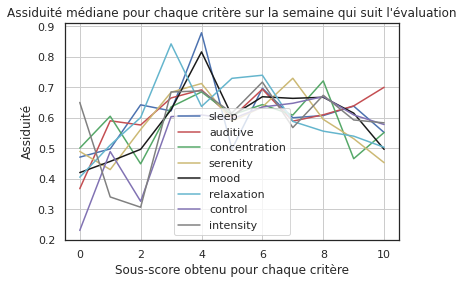

In [53]:
plt.plot(X_S_subscore, Y_S_sleep_mediane, color='b',label='sleep') # les Y_S pour l'assiduite et X_S pour valeur du score
plt.plot(X_S_subscore, Y_S_auditive_mediane, color='r',label='auditive')
plt.plot(X_S_subscore, Y_S_concentration_mediane, color='g',label='concentration')
plt.plot(X_S_subscore, Y_S_serenity_mediane, color='y',label='serenity')
plt.plot(X_S_subscore, Y_S_mood_mediane, color='k',label='mood')
plt.plot(X_S_subscore, Y_S_relaxation_mediane, color='c',label='relaxation')
plt.plot(X_S_subscore, Y_S_control_mediane, color='m',label='control')
plt.plot(X_S_subscore, Y_S_intensity_mediane, color='gray',label='intensity')
plt.grid(True)
plt.xlabel('Sous-score obtenu pour chaque critère')
plt.ylabel("Assiduité")
plt.title("Assiduité médiane pour chaque critère sur la semaine qui suit l'évaluation")
plt.legend(loc=0)
plt.show()

On constate que lorsqu'on utilise la médiane des assiduités qu lieu de leur moyenne la plage de valeur de l'assiduité se réduit. En outre les tendances de variations de l'assiduité avec les valeurs prises par les sous scores deviennent différentes d'un critère de l’évaluation wfu à l'autre.

ِOn cherche donc les corrélations entre les valeurs des différents sous-scores et l'assiduité médiane sur la semaine qui suit ce score. 

In [54]:
#on prend juste les correlations entre les val d'assiduité et le sous_score pour chaque question des 8
cor_concentration = np.corrcoef(X_S_subscore, Y_S_concentration_mediane)[1][0]
cor_intensity = np.corrcoef(X_S_subscore, Y_S_intensity_mediane)[1][0]
cor_sleep = np.corrcoef(X_S_subscore, Y_S_sleep_mediane)[1][0]
cor_mood = np.corrcoef(X_S_subscore, Y_S_mood_mediane)[1][0]
cor_serenity = np.corrcoef(X_S_subscore, Y_S_serenity_mediane)[1][0]
cor_relaxation = np.corrcoef(X_S_subscore, Y_S_relaxation_mediane)[1][0]
cor_auditive = np.corrcoef(X_S_subscore, Y_S_auditive_mediane)[1][0]
cor_control = np.corrcoef(X_S_subscore, Y_S_control_mediane)[1][0]

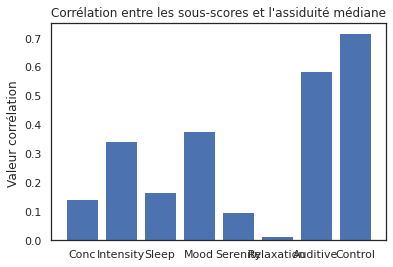

In [55]:
X_cor = ['Conc','Intensity','Sleep','Mood','Serenity','Relaxation','Auditive','Control']
Y_cor = [cor_concentration,cor_intensity,cor_sleep,cor_mood,cor_serenity,cor_relaxation,cor_auditive,cor_control]
plt.bar(X_cor,Y_cor)
plt.ylabel('Valeur corrélation ')
plt.title("Corrélation entre les sous-scores et l'assiduité médiane")
plt.show()

On remarque que l'assiduité_médiane n'est pas corrélée avec la relaxation(0.01) et la sérénité(0.09) par contre elle est plus corrélée avec le critère de Control positivement. Les différents sous_scores n'affectent pas de la même façon l'assiduité sur la semaine qui suit une évaluation contrairement au cas ou on considère l’assiduité_moyenne sur les patients avec un même sous_score. Il est dans notre cas plus fiable de travailler avec la médiane comme métrique comme on trouve des patients sur la base de données qui peuvent avoir des taux de complétion des objectifs qui leur sont recommandées trop élevés ce qui peut fausser les résultats. 

## Conclusion : 
On conclut qu'il y a quand même une certaine corrélation entre l'assiduité moyenne des utilisateurs et leur score wfu. Pour des scores inférieurs à 60, l'assiduité augmente avec le score, ce qui est tout à fait intuitif : plus une personne souffre de son acouphène, plus elle est sujette à l'inquiétude et donc à l'engagement sérieux dans la thérapie. Néanmoins, notre étude a démontré que pour les utilisateurs dont les scores dépassent 60, l'assiduité n'était pas toujours au rendez-vous. Peut-être cela est-il dû à une très forte inquiétude qui tend à susciter de l'angoisse, et c'est pour cela que nous proposons la solution de l'accompagnement psychologique personnalisé pour ces utilisateurs.

Cependant si on travaille avec des assiduité médianes on peut distinguer les sous-scores qui sont plus corrélées à l'assiduité des patients une fois ils prennent conscience de la nuisibilité que leur acouphène leur cause. En particulier la difficulté d'ignorer ses acouphènes rend un patient plus engagé à suivre les thérapies proposées. 